<a href="https://colab.research.google.com/github/gluoneros/greenPredEnergy/blob/main/Trabajo_Final__Revisado2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Proyecto Final - TalentoTech**

Modelo de clasificación de viabilidad de proyectos de energia renovable en los municipios de Colombia

## Descripcion 🚀

A través del análisis de datos energéticos y meteorológicos, de los municipios, este modelo evalua y predice la viabilidad de un proyecto de energía renovable. Con la información que brinda este algoritmo de machine learning los inversores y los gobiernos locales tienen la oportunidad de evaluar y reducir los costos de un proyecto de energía solar o eólica basandose en un porcentaje de viabilidad predicho por el modelo.



# **Objetivo**
Evaluar la viabilidad de un proyecto de energía eólica en los municipios de Colombia, por medio de datos meteorológicos y energéticos del año 2024, con el fin de impulsar el desarrollo municipal del país y salvaguardar las inversiones de aquellos interesados en crear un proyecto de energía renovable, tipo solar o eólico, a través de un porcentaje de viabilidad.


# **1. Importaciones**

**Requerimientos para consumo de API**

In [1]:
#Cliente de python para consumo de API
#!pip install sodapy #requerimientos para usar datos del gobierno

**Bibliotecas**


In [1]:
#Bibliotecas
  # Manejo de datos
import pandas as pd
import numpy as np

  # Visualización de datos
import matplotlib.pyplot as plt
import seaborn as sns

  # Despliegue
import pickle

**Librerías**

In [2]:
#Librerías
  #Modelo
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB, GaussianNB, BernoulliNB

  #Métricas
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, auc, roc_curve, roc_auc_score

  #Preprocesamiento
from sklearn.impute import KNNImputer
from sklearn.preprocessing import RobustScaler

  #Catálogo de datos abiertos
from sodapy import Socrata

In [3]:
#Clientes de API
client = Socrata("www.datos.gov.co", None)

# **2. Carga y Procesamiento de datos**

En esta sección se descargarán los datasets y se harán un preprocesamiento de los datos.

**Dataframe No. 1:**
---
Estado de la prestación del servicio de energía en Zonas No Interconectadas
[enlace](https://www.datos.gov.co/Minas-y-Energ-a/Estado-de-la-prestaci-n-del-servicio-de-energ-a-en/3ebi-d83g/about_data)



**Descarga y agrupamiento de datos**

In [4]:
results1 = client.get("3ebi-d83g", limit=5000) #Del cliente, pyhton va a descargar 5000 archivos

In [5]:
#Carga de datos
datos1 = pd.DataFrame.from_records(results1)
datos1.head()

,id_dpto,dpto,id_mpio,mpio,id_localidad,localidad,anio,mes,energia_activa,energia_reactiva,potencia_maxima,dia_demanda_maxima,fecha_demanda_maxima,prom_diario_horas
0,91,AMAZONAS,91540,PUERTO NARIÑO,91540000,PUERTO NARIÑO (PUERTO NARIÑO - AMAZONAS),2024,05,132215,41907,286.4,Jueves,2024-05-23T18:00:00.000,24
1,91,AMAZONAS,91798,TARAPACA (ANM),91798000,TARAPACA (TARAPACA (ANM) - AMAZONAS),2024,05,28132,12662,102.6,Viernes,2024-05-03T18:30:00.000,10.16
2,5,ANTIOQUIA,5873,VIGÍA DEL FUERTE,5873010,LA PLAYA MURRI (VIGÍA DEL FUERTE - ANTIOQUIA),2024,05,2686,1110,27.46,Martes,2024-05-21T19:45:00.000,4.19
3,88,ARCHIPIÉLAGO DE SAN ANDRÉS y PROVIDENCIA,88564,PROVIDENCIA,88564000,PROVIDENCIA (PROVIDENCIA - ARCHIPIÉLAGO DE SAN...,2024,05,1331271,284638,2190.28,Viernes,2024-05-10T15:00:00.000,23.59
4,13,BOLÍVAR,13001,CARTAGENA DE INDIAS,13001007,ISLA FUERTE (CARTAGENA DE INDIAS - BOLÍVAR),2024,05,64368,30561,247.59,Sábado,2024-05-18T22:00:00.000,10.9


In [6]:
#Creación de una nueva tabla a partir de los variables de interés
df1 = pd.DataFrame(
    {'municipio': datos1['mpio'],
    'potencia_m': datos1['potencia_maxima'],
    'energia_activa': datos1['energia_activa'],
    'energia_reactiva': datos1['energia_reactiva']
    }
)

**Exploración de los datos**

In [7]:
# A través de este comando se analizan las características del dataset tales como el tipo del objeto, el tamaño de la tabla.
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4273 entries, 0 to 4272
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   municipio         4273 non-null   object
 1   potencia_m        4273 non-null   object
 2   energia_activa    4273 non-null   object
 3   energia_reactiva  4273 non-null   object
dtypes: object(4)
memory usage: 133.7+ KB


In [8]:
df1.isnull().sum() #conteo de valores nulos en el dataset

municipio           0
potencia_m          0
energia_activa      0
energia_reactiva    0
dtype: int64

In [9]:
#Conversión de los datos categóricos de interés a datos numéricos
df1['potencia_m'] = pd.to_numeric(df1['potencia_m'], errors='coerce')
df1['energia_activa'] = pd.to_numeric(df1['energia_activa'], errors='coerce')
df1['energia_reactiva'] = pd.to_numeric(df1['energia_reactiva'], errors='coerce')
df1

,municipio,potencia_m,energia_activa,energia_reactiva
0,PUERTO NARIÑO,286.40,132215,41907.0
1,TARAPACA (ANM),102.60,28132,12662.0
2,VIGÍA DEL FUERTE,27.46,2686,1110.0
3,PROVIDENCIA,2190.28,1331271,284638.0
4,CARTAGENA DE INDIAS,247.59,64368,30561.0
...,...,...,...,...
4268,BUENAVENTURA,31.23,7610,3285.0
4269,CARURÚ,87.82,31775,7881.0
4270,MITÚ,3236.71,1590470,387197.0
4271,TARAIRA,136.84,39226,10719.0


In [10]:
# Se verifica conversion a numerico
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4273 entries, 0 to 4272
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   municipio         4273 non-null   object 
 1   potencia_m        4273 non-null   float64
 2   energia_activa    4273 non-null   int64  
 3   energia_reactiva  4273 non-null   float64
dtypes: float64(2), int64(1), object(1)
memory usage: 133.7+ KB


**Tratamiento de datos**

Valores repetidos

<Axes: xlabel='potencia_m', ylabel='Count'>

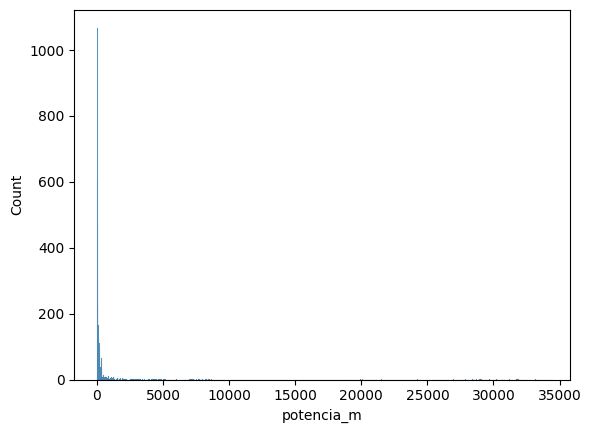

In [11]:
#Visualización de los datos previo a la selección posible de media o mediana
sns.histplot(df1['potencia_m'])

<Axes: xlabel='energia_activa', ylabel='Count'>

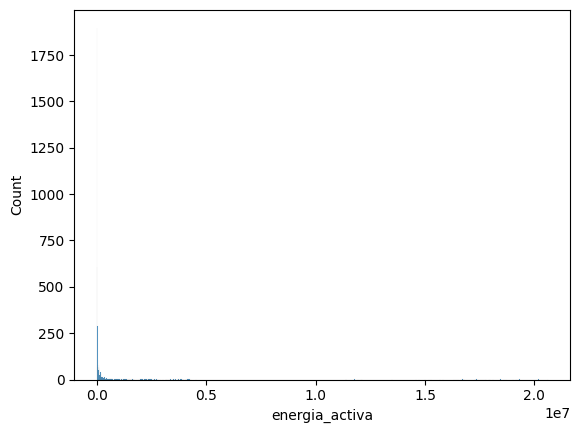

In [12]:
#Visualización de los datos previo a la selección posible de media o mediana
sns.histplot(df1['energia_activa'])

<Axes: xlabel='energia_reactiva', ylabel='Count'>

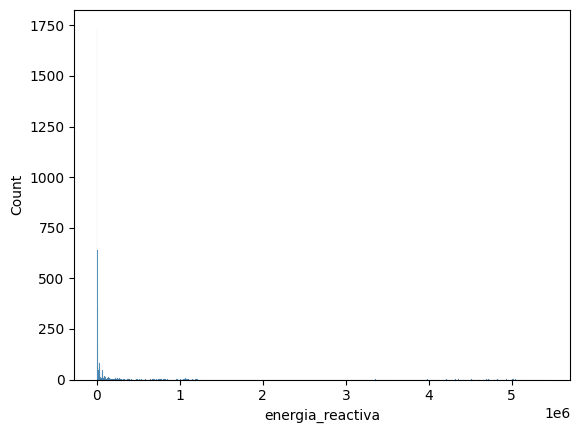

In [13]:
#Visualización de los datos previo a la selección posible de media o mediana
sns.histplot(df1['energia_reactiva'])

In [14]:
# Para depurar el dataset de variables repetidas se usa esa esta forma
  # Por cada municipio único va a sacar la media de los datos correspondientes a este lugar
energy = df1.groupby('municipio').agg({'potencia_m': 'mean', 'energia_activa': 'median', 'energia_reactiva': 'mean'}).reset_index()
#Creamos una tabla nueva con los datos únicos
energy

,municipio,potencia_m,energia_activa,energia_reactiva
0,ACANDI,830.817500,496707.5,139347.887500
1,ACANDÍ,816.094078,388026.0,127895.689320
2,ALTO BAUDO,107.021250,52660.0,14539.250000
3,ALTO BAUDO (PIE DE PATO),108.590000,46705.0,16143.490000
4,ALTO BAUDÓ,114.050000,47341.0,15989.000000
...,...,...,...,...
90,UNGUÍA,356.366078,20480.0,49519.810458
91,URIBIA,235.369333,38023.0,11364.911111
92,URIBÍA,188.310000,44960.5,9129.250000
93,VIGIA DEL FUERTE,35.810000,3567.0,393.350000


Nótese que de 4273 municipios repetidos pasamos a 95 municipios únicos

In [15]:
# Evaluación de los municipios
energy['municipio'].value_counts().sum()

np.int64(95)

In [16]:
# Análisis de caractaríticas
energy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95 entries, 0 to 94
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   municipio         95 non-null     object 
 1   potencia_m        95 non-null     float64
 2   energia_activa    95 non-null     float64
 3   energia_reactiva  95 non-null     float64
dtypes: float64(3), object(1)
memory usage: 3.1+ KB


**Visualización de los datos**

Media: 1055.4624708172898
Mediana: 113.20821428571428


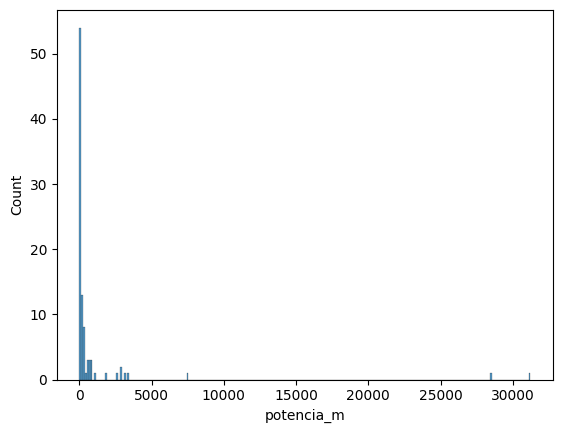

In [17]:
#Visualización de los datos de energía reactiva con sus medias y medianas
sns.histplot(energy['potencia_m'])
print('Media:',energy['potencia_m'].mean())
print('Mediana:', energy['potencia_m'].median())

Media: 573772.3157894737
Mediana: 20535.0


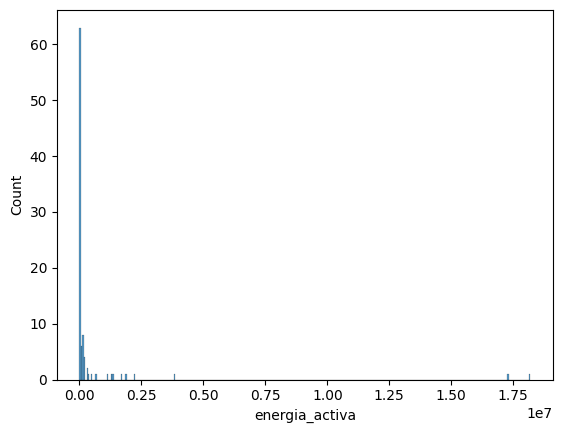

In [18]:
#Visualización de los datos de energía activa con sus medias y medianas
sns.histplot(energy['energia_activa'])
print('Media:', energy['energia_activa'].mean())
print('Mediana:', energy['energia_activa'].median())

Media: 161394.82788102192
Mediana: 10943.466666666667


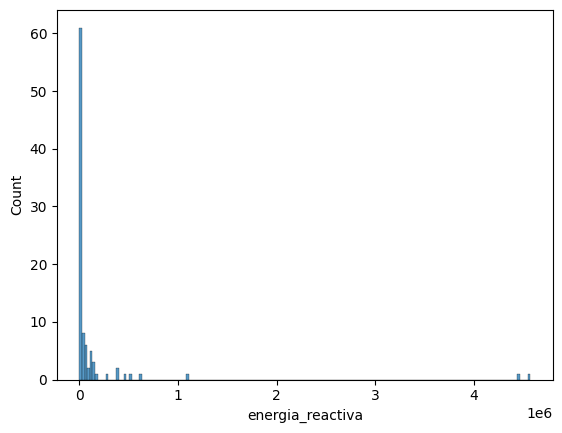

In [19]:
#Visualización de los datos de energía reactiva con sus medias y medianas
sns.histplot(energy['energia_reactiva'])
print('Media:',energy['energia_reactiva'].mean())
print('Mediana:', energy['energia_reactiva'].median())

<Axes: >

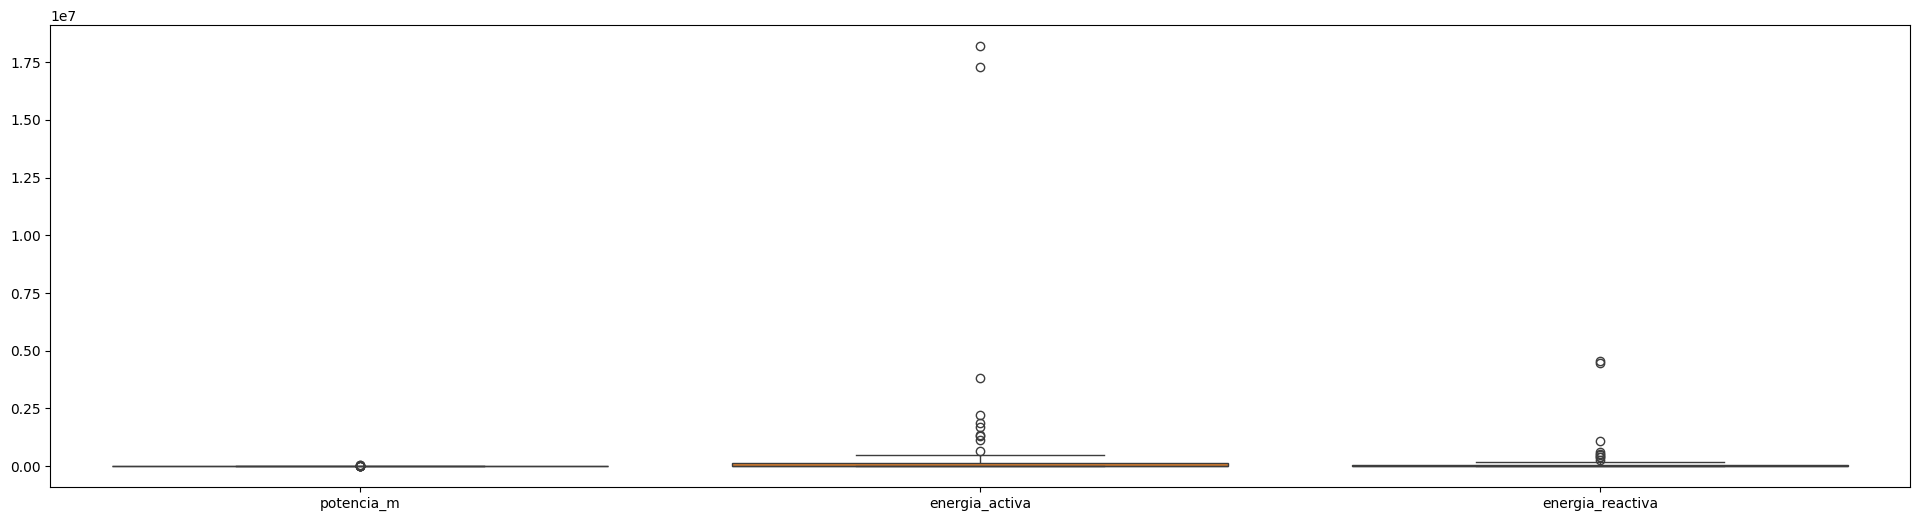

In [20]:
#visualización de la calidad de los datos
plt.figure(figsize=(24, 6))
columnas = energy[['potencia_m', 'energia_activa', 'energia_reactiva']]
sns.boxplot(columnas, whis=3)

Notemos que los datos de energía tienen muchos **datos atipicos**, además de una escala inmensa, a comparación con potencia máxima

<Axes: >

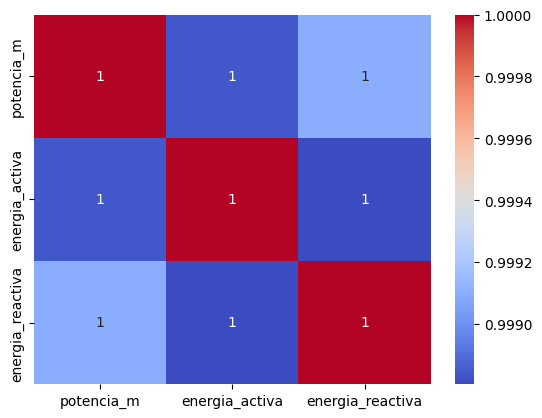

In [21]:
#Analisis de correlacion multivariada entre las variables de interes.
correlacion1 = energy[['potencia_m', 'energia_activa',	'energia_reactiva']].corr()
sns.heatmap(correlacion1, annot=True, cmap='coolwarm')

Existe una multicolinealidad muy alta entre las variables, esto significa que hay correlacion fuerte.

**Dataframe No. 2:**
---
Velocidad del viento en los municipios de colombia
[vínculo](https://www.datos.gov.co/Ambiente-y-Desarrollo-Sostenible/Velocidad-Viento/sgfv-3yp8/about_data)


**Descarga y agrupamiento de lo datos**

In [22]:
#Descarga y emuestra el dataset
results2 = client.get("sgfv-3yp8", limit=3000)
datos2 = pd.DataFrame.from_records(results2)
datos2

,codigoestacion,codigosensor,fechaobservacion,valorobservado,nombreestacion,departamento,municipio,zonahidrografica,latitud,longitud,descripcionsensor,unidadmedida
0,0026065502,0103,2018-09-10T17:00:00.000,2.100336,TRINIDAD LA - AUT,CAUCA,PIENDAMÓ,CAUCA,2.750555556,-76.57916667,Velocidad Viento (10 min),m/s
1,0024035430,0103,2015-04-19T00:20:00.000,1.2,TUNGUAVITA - AUT,BOYACÁ,PAIPA,SOGAMOSO,5.745916667,-73.11636111,Velocidad Viento (10 min),m/s
2,0028035070,0103,2019-03-17T05:00:00.000,6.1,GUATAPURI - AUT,CESAR,VALLEDUPAR,CESAR,10.73213889,-73.39241667,Velocidad Viento (10 min),m/s
3,0026195501,0103,2019-02-10T15:35:00.000,0.2517844,ANDES - AUT,ANTIOQUIA,ANDES,CAUCA,5.660108333,-75.91413889,Velocidad Viento (10 min),m/s
4,0023065190,0103,2016-12-27T17:00:00.000,1.4,QUEBRADA NEGRA - AUT,CUNDINAMARCA,QUEBRADANEGRA,MEDIO MAGDALENA,5.137611111,-74.48125,Velocidad Viento (10 min),m/s
...,...,...,...,...,...,...,...,...,...,...,...,...
2995,0024025501,0103,2019-05-28T02:55:00.000,0.01506365,ALBERTO SANTOS - AUT,SANTANDER,SOCORRO,SOGAMOSO,6.493052778,-73.22111111,Velocidad Viento (10 min),m/s
2996,0024035390,0103,2015-01-04T05:40:00.000,7.4,PARAMO ALMORZADERO - AUT,SANTANDER,CERRITO,SOGAMOSO,6.945388889,-72.69633333,Velocidad Viento (10 min),m/s
2997,0023035030,0103,2011-01-14T17:00:00.000,0.2,BASE PALANQUERO - AUT,CUNDINAMARCA,PUERTO SALGAR,MEDIO MAGDALENA,5.492861111,-74.658,Velocidad Viento (10 min),m/s
2998,0016015130,0103,2011-08-06T08:30:00.000,1.2,ALCALDIA DE HERRAN - AUT,NORTE DE SANTANDER,HERRÁN,CATATUMBO,7.506722222,-72.48536111,Velocidad Viento (10 min),m/s


In [23]:
#Agrupamiento de variables de interés
df2 = pd.DataFrame(
    {'municipio': datos2['municipio'],
     'velocidad_viento': datos2['valorobservado']
    }
)
df2

,municipio,velocidad_viento
0,PIENDAMÓ,2.100336
1,PAIPA,1.2
2,VALLEDUPAR,6.1
3,ANDES,0.2517844
4,QUEBRADANEGRA,1.4
...,...,...
2995,SOCORRO,0.01506365
2996,CERRITO,7.4
2997,PUERTO SALGAR,0.2
2998,HERRÁN,1.2


**Exploración de los datos**

In [24]:
df2.info() #Características de los datos

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   municipio         3000 non-null   object
 1   velocidad_viento  3000 non-null   object
dtypes: object(2)
memory usage: 47.0+ KB


Notemos que la variable, la velocidad del viento, está descrita como un objeto por lo que es necesario transformarla en numérico

In [25]:
#pasar la columna velocidad_viento a numérico
df2['velocidad_viento'] = pd.to_numeric(df2['velocidad_viento'], errors='coerce')

In [26]:
df2.isnull().sum() #Conteo de valores nulos

municipio           0
velocidad_viento    0
dtype: int64

Media: 1.943924209389453
Mediana: 1.4


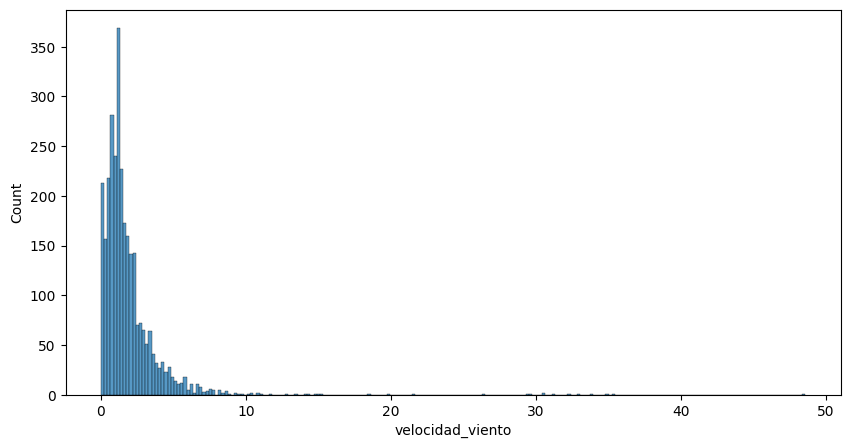

In [27]:
# Con el objetivo agrupar los datasets por municipio se evalua con graficas de boxplot y hisplot cuales datos estadisticos funcionarian mejor para ser un dato unico por cada uno de los municipios(que sera unico) en la columna 'municipio'.
plt.figure(figsize=(10, 5))
sns.histplot(df2['velocidad_viento'])
print('Media:',df2['velocidad_viento'].mean())
print('Mediana:', df2['velocidad_viento'].median())

Media: 1.943924209389453
Mediana: 1.4


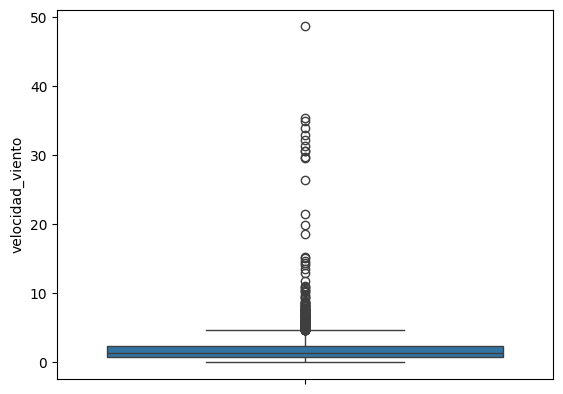

In [28]:
sns.boxplot(df2['velocidad_viento'])
print('Media:',df2['velocidad_viento'].mean())
print('Mediana:', df2['velocidad_viento'].median())

Notemos que la velocidad del viento tiene muchos outliers que afectan el valor de la media, por lo que cualquier tratamiento se recomienda hacer con la **MEDIANA**

**Tratamiento de datos**

Valores repetidos

In [29]:
# Por cada municipio único va a sacar la mediana de los datos correspondientes a este lugar
viento = df2.groupby('municipio').agg({'velocidad_viento': 'median'}).reset_index()
viento

,municipio,velocidad_viento
0,ABRIAQUÍ,0.800000
1,ACANDÍ,1.050000
2,ACEVEDO,2.338382
3,AGUACHICA,1.400000
4,AGUSTÍN CODAZZI,1.400000
...,...,...
287,YOLOMBÓ,1.500000
288,YOPAL,0.900000
289,ZETAQUIRÁ,0.500000
290,ZIPAQUIRÁ,2.000000


Media: 1.7090820023893836
Mediana: 1.3


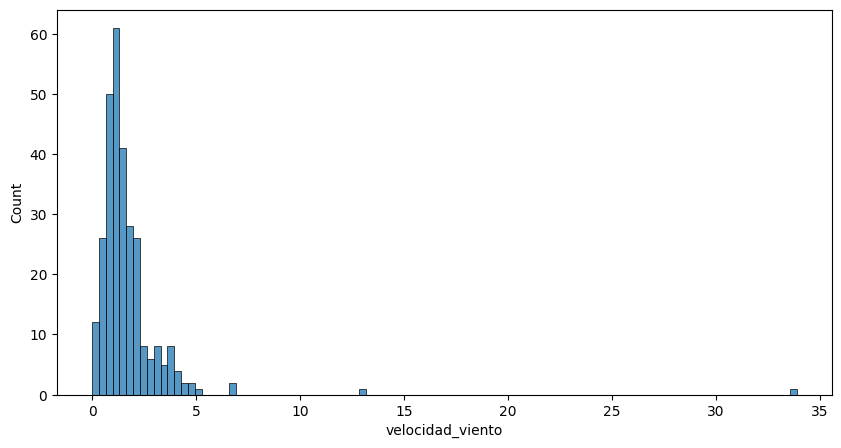

In [30]:
plt.figure(figsize=(10, 5))
sns.histplot(viento['velocidad_viento'])
print('Media:',viento['velocidad_viento'].mean())
print('Mediana:', viento['velocidad_viento'].median())

<Axes: ylabel='velocidad_viento'>

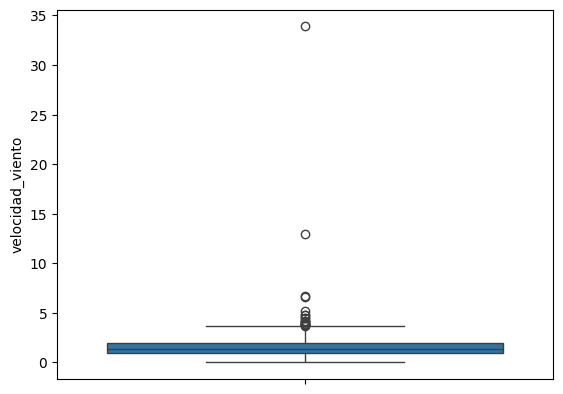

In [31]:
sns.boxplot(viento['velocidad_viento'])

In [32]:
#Evaluación del método
viento['municipio'].value_counts().sum()

np.int64(292)

**Dataframe No. 4:**
---
Dias con lluvia en los municipios de colombia:

INFORMACIÓN GENERAL ESTACIONES,,,,,,,,,NORMAL CLIMATOLÓGICA ESTÁNDAR DE No DE DÍAS CON LLUVIA ≥ 1 mm PARA EL PERIODO 1991-2020,,,,,,,,,,,,,  Cumplen la directriz No 1203 del 2017 de la OMM, [vínculo](http://archivo.ideam.gov.co/web/tiempo-y-clima/clima)

**Descarga y agrupamiento de los datos**

In [33]:
#Descarga de los datos
datos3 = pd.read_csv('https://raw.githubusercontent.com/gluoneros/talentoTech/refs/heads/main/noDiasLLuvia.csv')
datos3

,CODIGO,CATEGORIA,ESTACIÓN,MUNICIPIO,DEPARTAMENTO,AO,ALTITUD (m),LONGITUD,LATITUD,ENE,...,JUN,JUL,AGO,SEP,OCT,NOV,DIC,ANUAL,Número de meses,% de cumplimiento
0,47067010,LM,El Encanto,El Encanto,Amazonas,7,120,"-73,20","-1,77","14,3",...,"18,8","17,7","13,4","13,3","13,9","14,8","16,4","191,7",332,"92,2%"
1,47060010,PM,El Encato,El Encanto,Amazonas,7,120,"-73,21","-1,75","14,3",...,"18,6","17,8","13,1","13,3","13,8","14,9","16,3","191,1",343,"95,3%"
2,44187030,LM,Bacuri,La Pedrera,Amazonas,4,101,"-69,47","-1,23","19,0",...,"20,3","19,6","16,5","14,5","15,1","15,0","18,8","216,0",343,"95,3%"
3,44187020,PM,La Pedrera,La Pedrera,Amazonas,4,102,"-69,59","-1,31","13,8",...,"14,7","13,5","12,4","11,2","12,0","12,1","13,3","161,8",334,"92,8%"
4,44157040,LM,Manacaro,La Pedrera,Amazonas,4,109,"-70,18","-1,53","18,3",...,"19,1","18,0","14,6","13,2","14,9","14,8","17,1","204,0",351,"97,5%"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1440,38015030,SP,Aeropuerto Puerto Carreño,Puerto Carreño,Vichada,3,57,"-67,49","6,18","1,0",...,"21,2","21,9","19,7","14,3","12,3","7,9","2,9","133,2",359,"99,7%"
1441,38017040,LM,Casuarito,Puerto Carreño,Vichada,3,65,"-67,64","5,68","2,1",...,"19,3","19,6","16,1","12,7","10,3","7,7","4,3","130,7",343,"95,3%"
1442,35260010,PM,Bonanza,Santa Rosalía,Vichada,3,112,"-70,85","5,14","1,1",...,"14,4","15,1","13,2","10,0","8,9","5,9","2,7","98,7",324,"90,0%"
1443,35260030,PM,Hato Burrunay,Santa Rosalía,Vichada,3,106,"-70,68","5,35","1,3",...,"15,3","17,1","14,0","12,1","10,8","7,7","3,6","113,4",349,"96,9%"


In [34]:
# Se seleccionan y grupan de los datos de  interés en un nuevo dataframe.
dato_lluvia = pd.DataFrame(
    {'municipio': datos3['MUNICIPIO'],
     'dias_lluvia': datos3['ANUAL']
    }
)
dato_lluvia

,municipio,dias_lluvia
0,El Encanto,"191,7"
1,El Encanto,"191,1"
2,La Pedrera,"216,0"
3,La Pedrera,"161,8"
4,La Pedrera,"204,0"
...,...,...
1440,Puerto Carreño,"133,2"
1441,Puerto Carreño,"130,7"
1442,Santa Rosalía,"98,7"
1443,Santa Rosalía,"113,4"


Notemos que la columna de días de lluvia tiene comas y espacios, lo que entorpece el análisis

**Exploración de los datos**

In [35]:
dato_lluvia.info() #Evaluación de las características del dataset

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1445 entries, 0 to 1444
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   municipio    1445 non-null   object
 1   dias_lluvia  1445 non-null   object
dtypes: object(2)
memory usage: 22.7+ KB


**Tratamiento de datos**

Manejo de errores en los datos

In [36]:
# Primero
 #Eliminación de los espacios en blanco
dato_lluvia['dias_lluvia'] = dato_lluvia['dias_lluvia'].str.strip()
dato_lluvia['municipio'] =  dato_lluvia['municipio'].str.strip()

In [37]:
# Segundo
 #Cambia comas por puntos en el campo 'dias_lluvia'
dato_lluvia['dias_lluvia'] =  dato_lluvia['dias_lluvia'].str.replace(',', '.', regex=False)

In [38]:
# Tercero
#Luego de la creacion del dataframe es necesario convertir los datos a numérico
dato_lluvia['dias_lluvia'] = pd.to_numeric(dato_lluvia['dias_lluvia'], errors='coerce')

In [39]:
# Cuarto
  #pasa municipio a mayusculas
dato_lluvia['municipio'] = dato_lluvia['municipio'].str.upper()
dato_lluvia

,municipio,dias_lluvia
0,EL ENCANTO,191.7
1,EL ENCANTO,191.1
2,LA PEDRERA,216.0
3,LA PEDRERA,161.8
4,LA PEDRERA,204.0
...,...,...
1440,PUERTO CARREÑO,133.2
1441,PUERTO CARREÑO,130.7
1442,SANTA ROSALÍA,98.7
1443,SANTA ROSALÍA,113.4


Manejo de datos repetidos

Media: 136.81058823529412
Mediana: 134.1


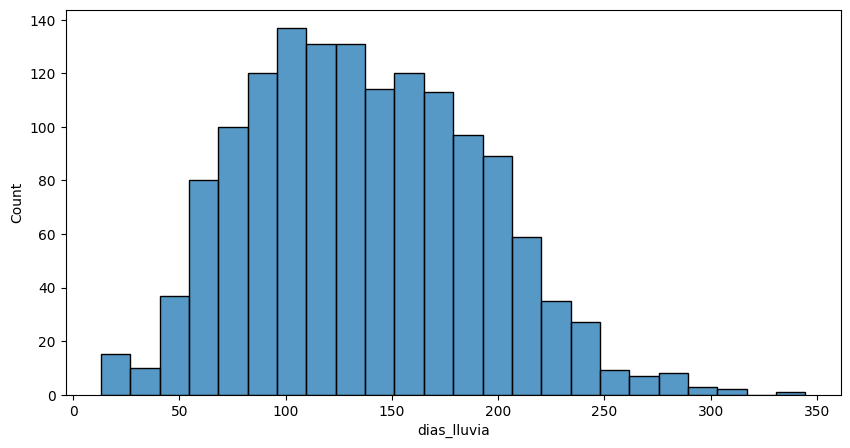

In [40]:
# Observasion visual para evaluar cual dato estadistico es el mejor para agrupar en funcion de municipio.
plt.figure(figsize=(10, 5))
sns.histplot(dato_lluvia['dias_lluvia'])
print('Media:',dato_lluvia['dias_lluvia'].mean())
print('Mediana:',dato_lluvia['dias_lluvia'].median())

In [41]:
# Por cada municipio único va a sacar la media de los datos correspondientes a este lugar
lluvia = dato_lluvia.groupby('municipio').agg({'dias_lluvia': 'median'}).reset_index() #,'longitud': 'first', 'latitud': 'first'
lluvia

,municipio,dias_lluvia
0,ABEJORRAL,177.80
1,ABRIAQUÍ,200.60
2,ACACÍAS,195.70
3,ACANDÍ,150.50
4,ACEVEDO,157.65
...,...,...
756,ZONA BANANERA,48.05
757,ÁBREGO,106.70
758,ÍQUIRA,166.50
759,ÚMBITA,170.20


In [42]:
lluvia['municipio'].value_counts().sum() #evaluación del método

np.int64(761)

Media: 139.37884362680683
Mediana: 137.6


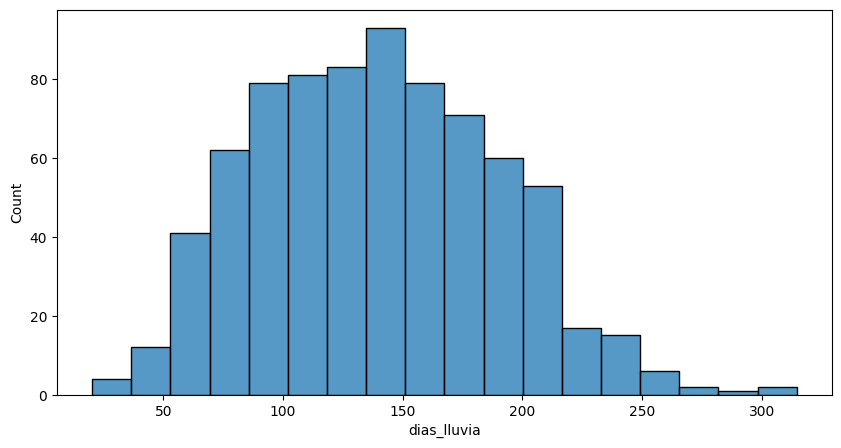

In [43]:
# Se observa nuevamente agrupacion similar
plt.figure(figsize=(10, 5))
sns.histplot(lluvia['dias_lluvia'])
print('Media:',lluvia['dias_lluvia'].mean())
print('Mediana:',lluvia['dias_lluvia'].median())

Notemos que de 1445 datos pasamos a tener 761 valores únicos

**Unificación de los datos**
---

Todos los datasets anteriormente tienen en común la columna de municipios por lo que esta va a ser la clave de unificación. Este método crea una nueva tabla que de la misma manera que antes necesita un tratamiento de datos


**1. Unificación y organización de datos de viento y lluvia**

In [44]:
# Se utiliza pd.merge left=viento right= lluvia para un dataframe en el cual
#municipio y velocidad_viento permaneceran con los mismos registros y se hara una comparasion con lluvia. Si los datos 'municipio' es un match en ambos datasets se ubica los datos que corresponda de 'dias_lluvia'. Si no se encuntran datos en 'dias_lluvia' se retorna un NaN. Si al hacer el match no habría datos en 'velocidad_viento' se descartaría la fila completa 'municipio'	'dias_lluvia' de el dataframe lluvia.
df_clima = pd.merge(left= viento, right= lluvia, left_on='municipio', right_on= 'municipio', how='left')
df_clima

,municipio,velocidad_viento,dias_lluvia
0,ABRIAQUÍ,0.800000,200.60
1,ACANDÍ,1.050000,150.50
2,ACEVEDO,2.338382,157.65
3,AGUACHICA,1.400000,92.60
4,AGUSTÍN CODAZZI,1.400000,77.95
...,...,...,...
287,YOLOMBÓ,1.500000,152.30
288,YOPAL,0.900000,149.60
289,ZETAQUIRÁ,0.500000,179.00
290,ZIPAQUIRÁ,2.000000,147.35


In [45]:
df_clima.info() #Evaluación de las condiciones de los datos del dataframe cuantitatrivos o nominales

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 292 entries, 0 to 291
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   municipio         292 non-null    object 
 1   velocidad_viento  292 non-null    float64
 2   dias_lluvia       221 non-null    float64
dtypes: float64(2), object(1)
memory usage: 7.0+ KB


**Tratamiento de datos**

In [46]:
df_clima.isnull().sum() #Conteo de valores nulos

municipio            0
velocidad_viento     0
dias_lluvia         71
dtype: int64

Media: 145.4185520361991
Mediana: 146.5


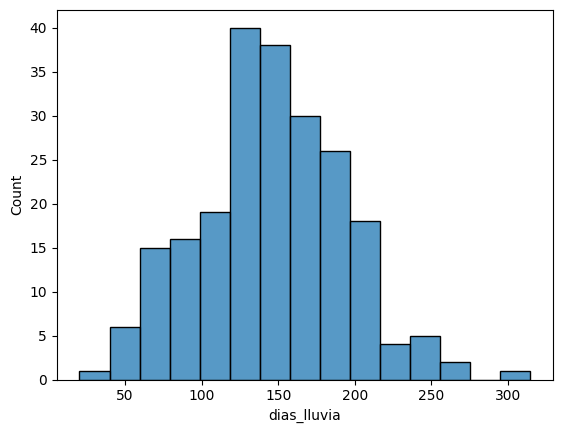

In [47]:
# Se observa una similitud numerica entre media y mediana
sns.histplot(df_clima['dias_lluvia'])
print('Media:',df_clima['dias_lluvia'].mean())
print('Mediana:', df_clima['dias_lluvia'].median())

Nótemos que la distribución de los datos es uniforme por lo que para el tratamiento de datos nulos se recomienda la **MEDIA**

Media: 1.7090820023893836
Mediana: 1.3


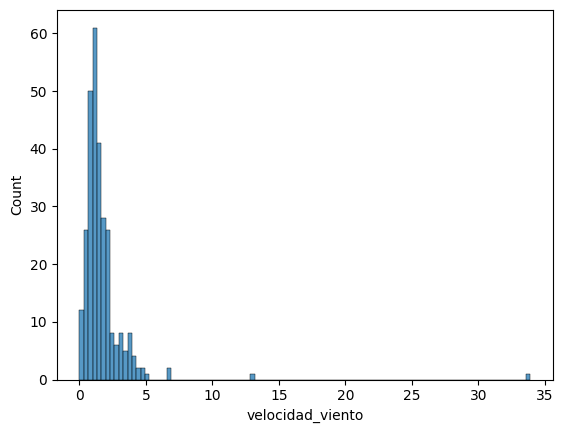

In [48]:
sns.histplot(df_clima['velocidad_viento'])
print('Media:',df_clima['velocidad_viento'].mean())
print('Mediana:', df_clima['velocidad_viento'].median())

Nótemos que la distribución de los datos está afectada por los datos atípicos  por lo que para el tratamiento de datos nulos se recomienda la **MEDIANA**

Manejo de datos faltantes

In [49]:
# Se rellenan los datos faltantes de los días de lluvia con el valor de la media
df_clima['dias_lluvia'] = df_clima['dias_lluvia'].fillna(df_clima['dias_lluvia'].mean())
df_clima

,municipio,velocidad_viento,dias_lluvia
0,ABRIAQUÍ,0.800000,200.60
1,ACANDÍ,1.050000,150.50
2,ACEVEDO,2.338382,157.65
3,AGUACHICA,1.400000,92.60
4,AGUSTÍN CODAZZI,1.400000,77.95
...,...,...,...
287,YOLOMBÓ,1.500000,152.30
288,YOPAL,0.900000,149.60
289,ZETAQUIRÁ,0.500000,179.00
290,ZIPAQUIRÁ,2.000000,147.35


In [50]:
df_clima.isnull().sum() #No se observan nulos

municipio           0
velocidad_viento    0
dias_lluvia         0
dtype: int64

In [51]:
df_clima['municipio'].value_counts().sum() #evaluación del método

np.int64(292)

**Visualización de los datos**

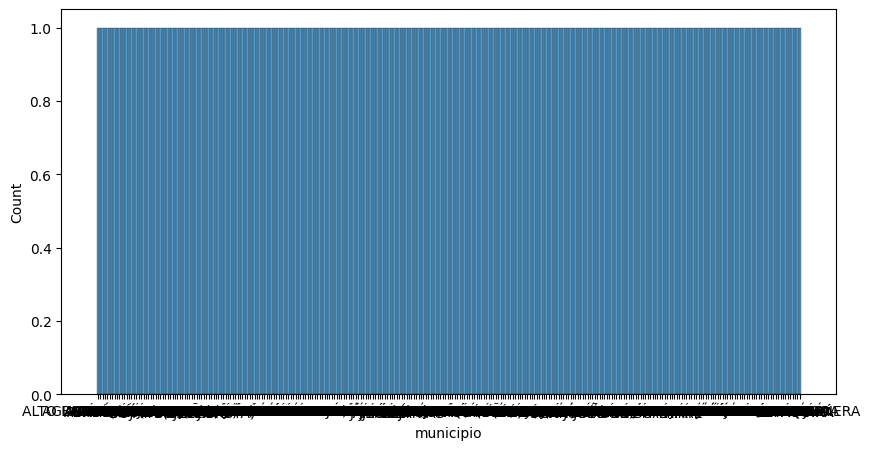

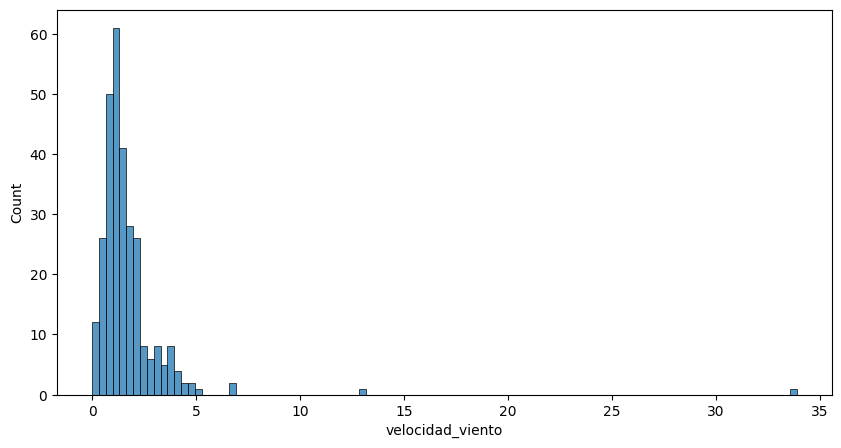

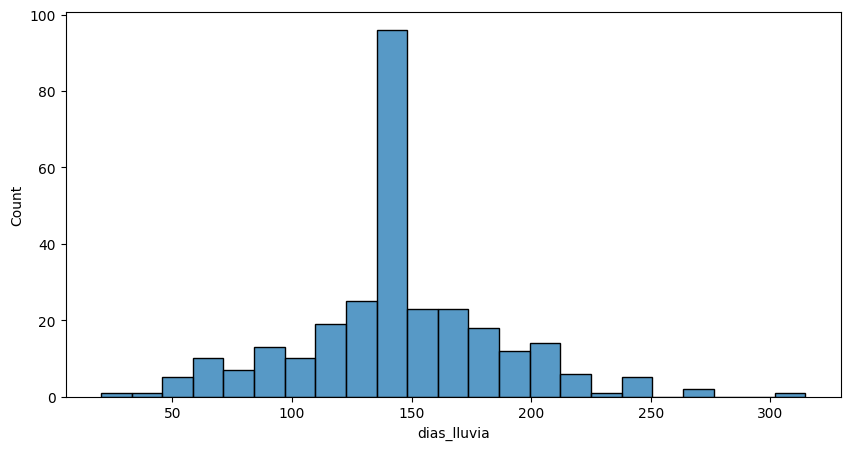

In [52]:
for col in df_clima.columns:
  plt.figure(figsize=(10, 5))
  sns.histplot(df_clima[col])


Notémos que debido al manejo que se les dió a los datos, la distribución de los días de lluvia cambió

<Axes: >

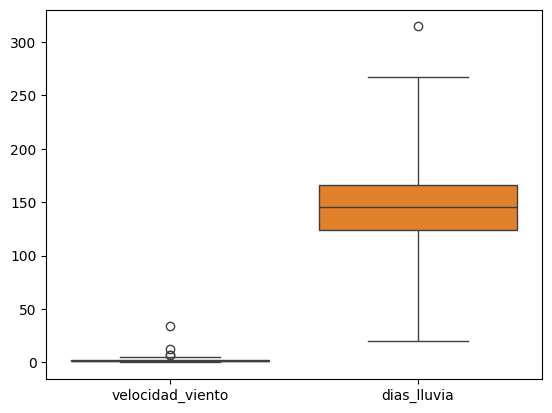

In [53]:
#Visualización de los datos para evaluar datos atípicos
climas = df_clima[['velocidad_viento', 'dias_lluvia']]
sns.boxplot(climas, whis=3)

Notémos que las escalas de los datos están muy diferentes por lo que no se puede ver el comportamiento de la variable de la velocidad del viento

**2. Unificación y organización de datos de energía y clima**

In [54]:
# Se utiliza pd.merge left=df_clima right= energy para un dataframe en el cual
#municipio velocidad_viento dias_lluvia permaneceran con los mismos registros y se hara una comparasion con energy. Si los datos 'municipio' es un match en ambos datasets se ubica los datos que corresponda en dichas filas. Si no se encuntran los datos de la izquierda retorna un NaN. Si al hacer el match no habría datos numericos en los datos de la derecha se descartaría la fila completa de energy'.
df_unificado = pd.merge(left = df_clima, right = energy, left_on='municipio', right_on= 'municipio', how='left')
df_unificado

,municipio,velocidad_viento,dias_lluvia,potencia_m,energia_activa,energia_reactiva
0,ABRIAQUÍ,0.800000,200.60,NaN,NaN,NaN
1,ACANDÍ,1.050000,150.50,816.094078,388026.0,127895.68932
2,ACEVEDO,2.338382,157.65,NaN,NaN,NaN
3,AGUACHICA,1.400000,92.60,NaN,NaN,NaN
4,AGUSTÍN CODAZZI,1.400000,77.95,NaN,NaN,NaN
...,...,...,...,...,...,...
287,YOLOMBÓ,1.500000,152.30,NaN,NaN,NaN
288,YOPAL,0.900000,149.60,NaN,NaN,NaN
289,ZETAQUIRÁ,0.500000,179.00,NaN,NaN,NaN
290,ZIPAQUIRÁ,2.000000,147.35,NaN,NaN,NaN


Notémos que de 291 datos del dataset final hay una cantidad de 268 nulos para el dataset de las energías. Este caso se da porque el dataset de base tiene más datos que la tabla visitante, sin que coincidan los municipios, por lo tanto llena los espacios con nulos.

Dado este caso se propone el método de imputación de valores el cual usa ######################

**Manejo de datos nulos: Método de imputación**

  1. Separación de los datos nulos

In [55]:
# Primero se separan los datos faltantes en una tabla
nulos = pd.DataFrame(
    {'potencia_m': df_unificado['potencia_m'],
    'energia_activa': df_unificado['energia_activa'],
    'energia_reactiva': df_unificado['energia_reactiva']
}
)
nulos

,potencia_m,energia_activa,energia_reactiva
0,NaN,NaN,NaN
1,816.094078,388026.0,127895.68932
2,NaN,NaN,NaN
3,NaN,NaN,NaN
4,NaN,NaN,NaN
...,...,...,...
287,NaN,NaN,NaN
288,NaN,NaN,NaN
289,NaN,NaN,NaN
290,NaN,NaN,NaN


In [56]:
nulos.info() #Evaluación de las características de la tabla

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 292 entries, 0 to 291
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   potencia_m        23 non-null     float64
 1   energia_activa    23 non-null     float64
 2   energia_reactiva  23 non-null     float64
dtypes: float64(3)
memory usage: 7.0 KB


  2. Imputación de valores

In [57]:
imputer = KNNImputer(n_neighbors=5)
df_imputados = pd.DataFrame(imputer.fit_transform(nulos), columns=nulos.columns)
df_imputados

,potencia_m,energia_activa,energia_reactiva
0,1847.674336,1.040489e+06,285776.402284
1,816.094078,3.880260e+05,127895.689320
2,1847.674336,1.040489e+06,285776.402284
3,1847.674336,1.040489e+06,285776.402284
4,1847.674336,1.040489e+06,285776.402284
...,...,...,...
287,1847.674336,1.040489e+06,285776.402284
288,1847.674336,1.040489e+06,285776.402284
289,1847.674336,1.040489e+06,285776.402284
290,1847.674336,1.040489e+06,285776.402284


Media: 1847.6743363246655
Mediana: 116.92922480620156
Media: 1040488.8260869565
Mediana: 14829.5
Media: 285776.4022838836
Mediana: 11364.91111111111


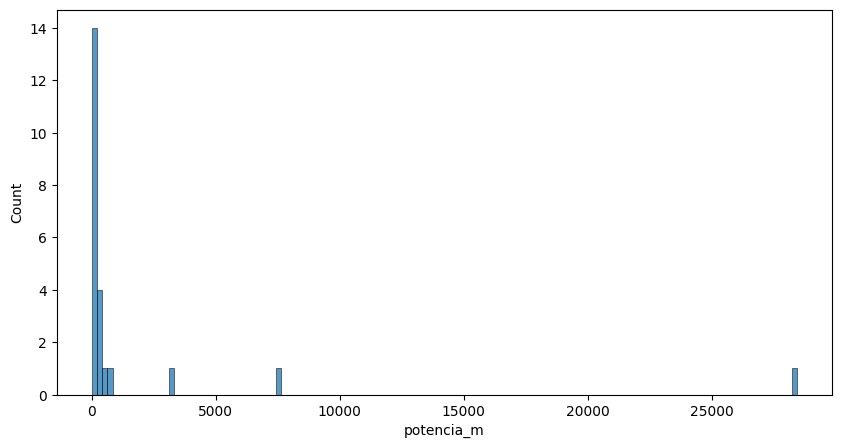

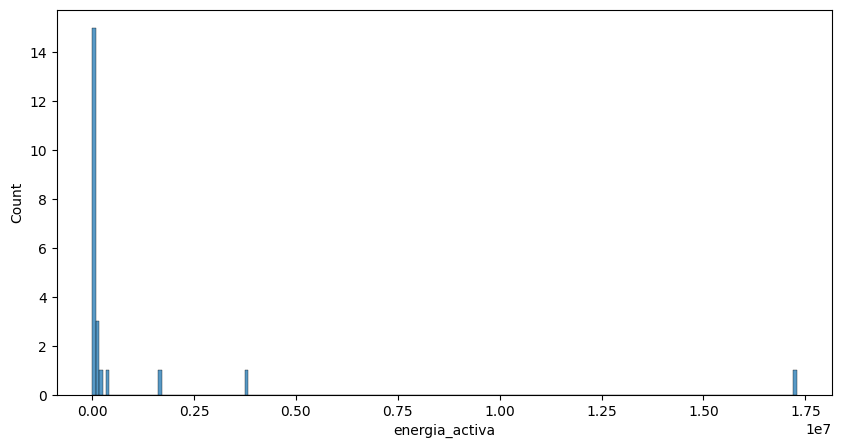

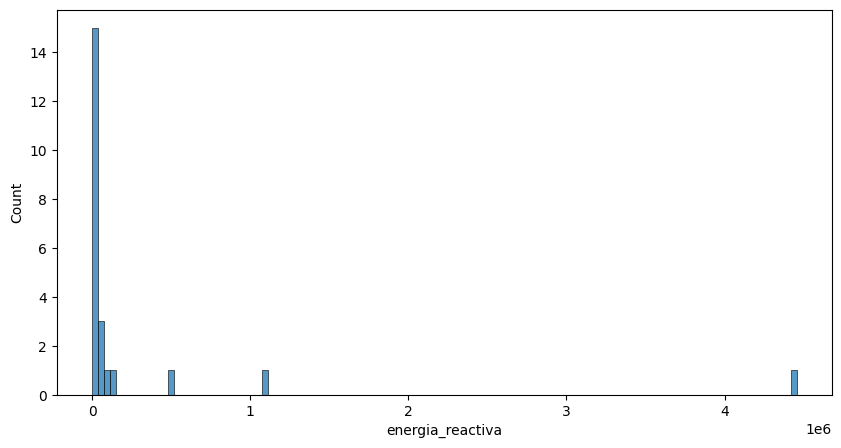

In [58]:
for col in nulos.columns:
  plt.figure(figsize=(10, 5))
  sns.histplot(nulos[col])
  print('Media:',nulos[col].mean())
  print('Mediana:', nulos[col].median())

  3. Unión de los datos imputados en el dataset final

In [59]:
# Unión de los datos de clima y las energías lado a lado sin cambios.
df_viabilidad = pd.concat([df_clima, df_imputados], axis=1)
df_viabilidad

,municipio,velocidad_viento,dias_lluvia,potencia_m,energia_activa,energia_reactiva
0,ABRIAQUÍ,0.800000,200.60,1847.674336,1.040489e+06,285776.402284
1,ACANDÍ,1.050000,150.50,816.094078,3.880260e+05,127895.689320
2,ACEVEDO,2.338382,157.65,1847.674336,1.040489e+06,285776.402284
3,AGUACHICA,1.400000,92.60,1847.674336,1.040489e+06,285776.402284
4,AGUSTÍN CODAZZI,1.400000,77.95,1847.674336,1.040489e+06,285776.402284
...,...,...,...,...,...,...
287,YOLOMBÓ,1.500000,152.30,1847.674336,1.040489e+06,285776.402284
288,YOPAL,0.900000,149.60,1847.674336,1.040489e+06,285776.402284
289,ZETAQUIRÁ,0.500000,179.00,1847.674336,1.040489e+06,285776.402284
290,ZIPAQUIRÁ,2.000000,147.35,1847.674336,1.040489e+06,285776.402284


In [60]:
df_viabilidad.isnull().sum() #Conteo de los datos

municipio           0
velocidad_viento    0
dias_lluvia         0
potencia_m          0
energia_activa      0
energia_reactiva    0
dtype: int64

Los proyectos de energía renovable, tipo eólico o solar, están fuertemente relacionados por el clima por lo que es posible determinar, prontamente si un municipio cumple con las especificaciones climáticas.

Por un lado, un proyecto de energía eólica requiere que haya una velocidad del viento de  mínimo 3,5 m/s. Por el otro lado, un proyecto de energía solar es viable en lugares donde llueva menos de 90 días al año. El tipo solar requiere de muchos más factores que solo los días despejados para determinar su viabilidad, sin embargo, la posición geográfica del país brinda una radiación solar suficiente para que un proyecto de esta clase se dé de manera exitosa con menos de 150 días de lluvia anual.

In [61]:
#Creación de la variable viabilidad a través del análisis climático de los municipios
  #La columna viabilidad responde a 1 si el municipio cumple con las condiciones del clima y 0 si no es así
df_viabilidad.loc[:, 'viabilidad'] = ((df_viabilidad['dias_lluvia'] < 150) | (df_viabilidad['velocidad_viento'] > 3.5)).astype(int)
df_viabilidad

,municipio,velocidad_viento,dias_lluvia,potencia_m,energia_activa,energia_reactiva,viabilidad
0,ABRIAQUÍ,0.800000,200.60,1847.674336,1.040489e+06,285776.402284,0
1,ACANDÍ,1.050000,150.50,816.094078,3.880260e+05,127895.689320,0
2,ACEVEDO,2.338382,157.65,1847.674336,1.040489e+06,285776.402284,0
3,AGUACHICA,1.400000,92.60,1847.674336,1.040489e+06,285776.402284,1
4,AGUSTÍN CODAZZI,1.400000,77.95,1847.674336,1.040489e+06,285776.402284,1
...,...,...,...,...,...,...,...
287,YOLOMBÓ,1.500000,152.30,1847.674336,1.040489e+06,285776.402284,0
288,YOPAL,0.900000,149.60,1847.674336,1.040489e+06,285776.402284,1
289,ZETAQUIRÁ,0.500000,179.00,1847.674336,1.040489e+06,285776.402284,0
290,ZIPAQUIRÁ,2.000000,147.35,1847.674336,1.040489e+06,285776.402284,1


In [62]:
df_viabilidad['viabilidad'].value_counts() #Conteo de los datos de viabilidad

viabilidad
1    197
0     95
Name: count, dtype: int64

# **3. Preprocesamiento de los datos**

Previamente se hizo un scouting de la condicione de los datos, pero ahora se entra más en detalle

**Visualización de las variables**

<Axes: >

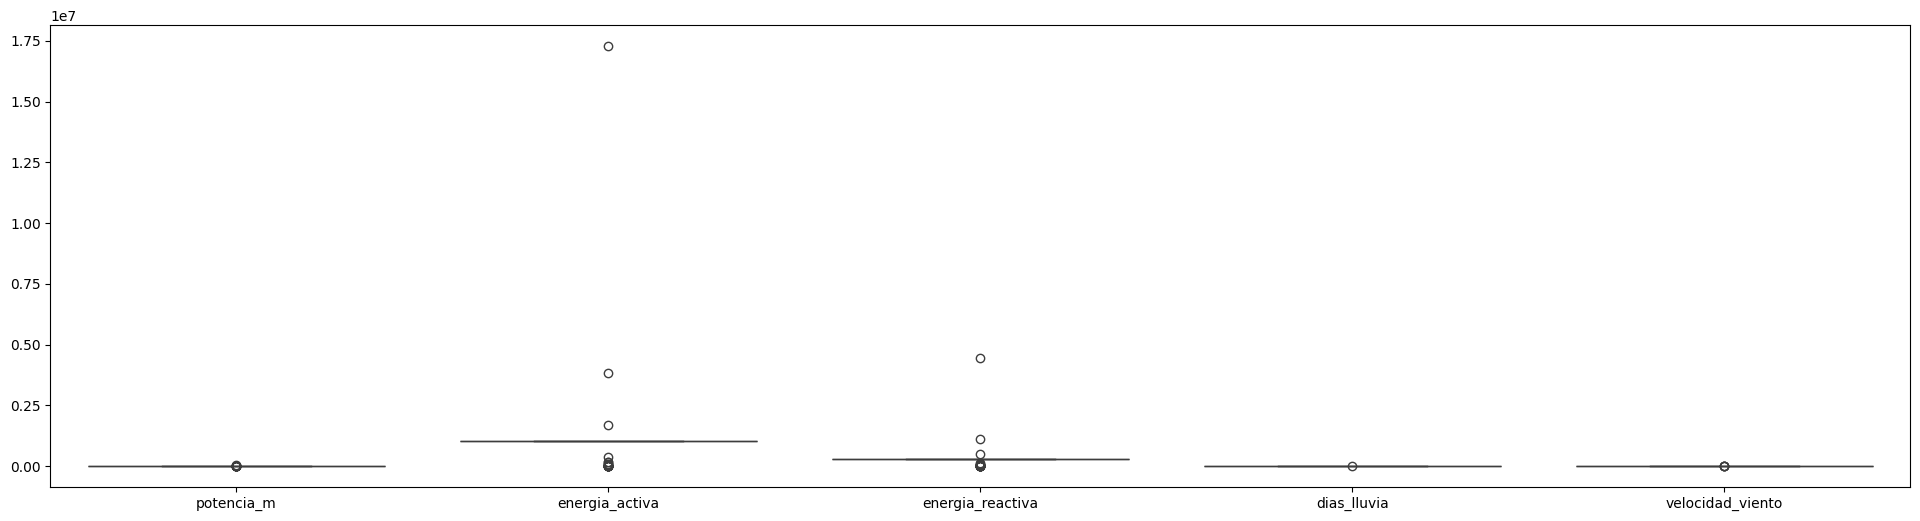

In [63]:
# Visualización del comportamiento de cada variable
plt.figure(figsize=(24, 6))
variables = df_viabilidad[['potencia_m', 'energia_activa', 'energia_reactiva', 'dias_lluvia', 'velocidad_viento']]
sns.boxplot(variables, whis=3)

Notémos que los datos presentan comportamientos atípicos que afectarán al modelo por lo que se recomienda hacer un tratamiento y una escalación de los mismos.

<Axes: >

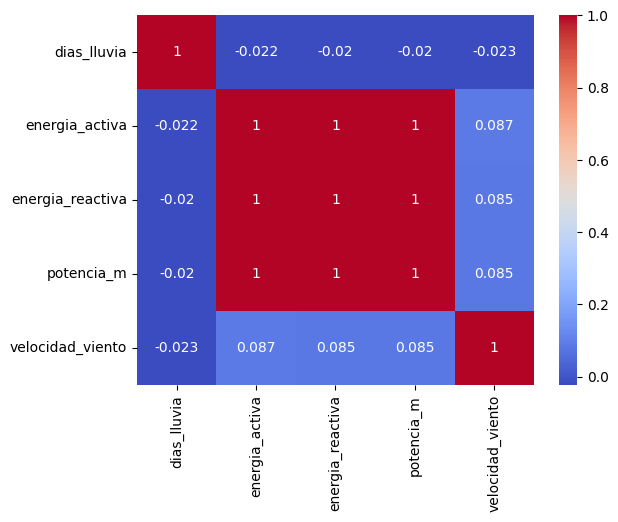

In [64]:
#Evaluación de correlación en el dataset final
correlacion = df_viabilidad[['dias_lluvia', 'energia_activa', 'energia_reactiva', 'potencia_m', 'velocidad_viento']].corr()

sns.heatmap(correlacion, annot=True, cmap='coolwarm')

La correlación aquí observada se debe, principalmente al comportamiento de los datos originales. Por otro lado, el tratamiento de imputación hace que sea más homogéneo este comportamiento.

# **4. Entrenamiento del Modelo**

Para el caso de estos datos se determinó que la naturaleza del modelo debería ser de clasificación. Este va a evaluar las variables energéticas y climáticas para predecir si un municipio es viable o no para un proyecto de energía renobale

## Modelo de clasificación NAIVE BAYES
---

A la par que se crea el modelo también se escalan los datos por medio del RobustScaler(), que nos brinda la facilidad de escalar y tratar los datos atípicos.

In [65]:
# se separan x de entradas y salida
x = df_viabilidad[[ 'energia_activa', 'energia_reactiva', 'dias_lluvia', 'velocidad_viento']]
y = df_viabilidad['viabilidad']
# Se divide set de entranmiento y prueba
x_entrenamiento, x_prueba, y_entrenamiento, y_prueba = train_test_split(x, y, test_size=0.2, random_state=42)
# Se utiliza escalador para las x, contiene outliers, no para y por que es 1 y 0
escalador = RobustScaler()
x_entrenamientox = escalador.fit_transform(x_entrenamiento)
x_pruebax = escalador.transform(x_prueba)
# Modelo de clasificasio que mejor se ajusto
naive_model = MultinomialNB()
naive_model.fit(x_entrenamiento, y_entrenamiento)
predicciones = naive_model.predict(x_prueba)

# **5. Evaluación del Modelo**

La evaluación del modelo se hizo a través de diferentes métricas y herramientas para segurar el correcto funcionamiento del mismo

**Cross Validation:** #########################

In [66]:
#Estas metricas evaluann el modelo y 'x' y 'y' seleccionadas en 3 particiones y dan un puntaje alto.
kfold1 = KFold(n_splits=3, shuffle=True, random_state=42)
cv_score1 = cross_val_score(naive_model, x, y, cv=kfold1)
print(cv_score1)
print(cv_score1.mean())

[0.8877551  0.79381443 0.88659794]
0.8560558243916123


**Accuracy y Classification report:** ###############################

In [67]:
print(classification_report(y_prueba, predicciones))
print('Accuracy:', accuracy_score(y_prueba, predicciones))


              precision    recall  f1-score   support

           0       0.76      0.76      0.76        17
           1       0.90      0.90      0.90        42

    accuracy                           0.86        59
   macro avg       0.83      0.83      0.83        59
weighted avg       0.86      0.86      0.86        59

Accuracy: 0.864406779661017


**Matriz de confusión : ################################

In [68]:
matriz1 = confusion_matrix(y_prueba, predicciones)
print(matriz1)

[[13  4]
 [ 4 38]]


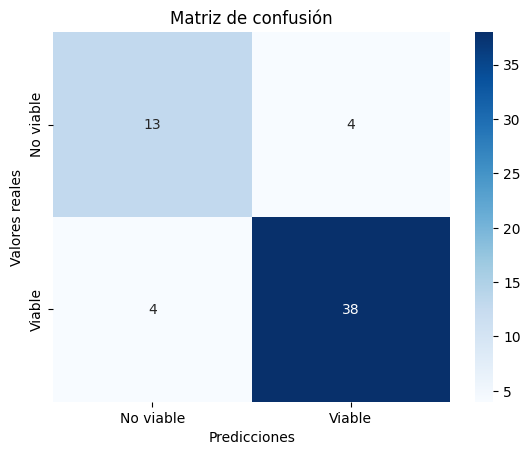

In [69]:
# Visualización de la matris de confusión
labels = ['No viable', 'Viable']

sns.heatmap(matriz1, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicciones')
plt.ylabel('Valores reales')
plt.title('Matriz de confusión')
plt.show()

**AUC y Curva ROC:**

In [70]:
predicciones = naive_model.predict_proba(x_prueba)[:, 1]

In [71]:
fpr, tpr, thresholds = roc_curve(y_prueba, predicciones)
auc = roc_auc_score(y_prueba, predicciones)
print(f"AUC: {auc}")

AUC: 0.9117647058823528


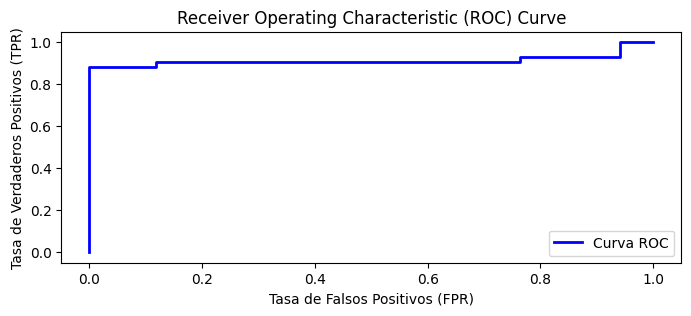

In [72]:
plt.figure(figsize=(8, 3))
plt.plot(fpr, tpr, color='blue', lw=2, label='Curva ROC' % auc)
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

**Comportamiento de Residuos:**

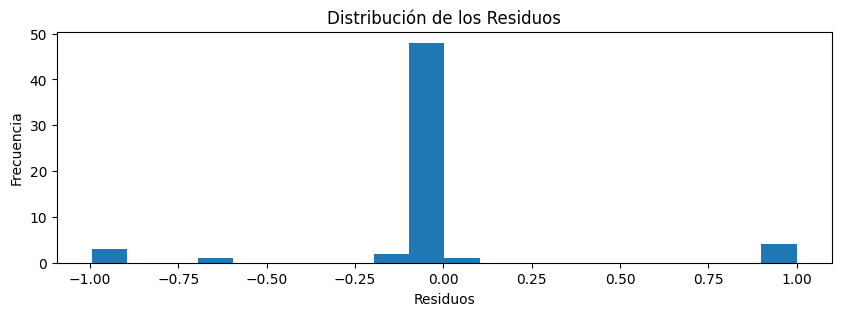

In [73]:
plt.figure(figsize=(10, 3))
residuos = y_prueba - predicciones
plt.hist(residuos, bins=20)
plt.xlabel("Residuos")
plt.ylabel("Frecuencia")
plt.title("Distribución de los Residuos")
plt.show()

# **6. Implementación**

Se tranforma el modelo en una aplicación amigable para el usuario, con la que este puede obtener información adicional acerca del contexto de la predicción.

##**Creación de una función de evaluación de viabilidad:**
Con esta el usuario puede ingresar un municipio de colombia y este va a arrojaruna predicción basada en la información recopilada

In [74]:
def predecir_viabilidad_municipio(municipio, modelo, df_viabilidad):

  municipio = municipio.upper()  # Convertir el nombre del municipio a mayúsculas

  # Buscar el municipio en el DataFrame
  datos_municipio = df_viabilidad[df_viabilidad['municipio'] == municipio]

  if datos_municipio.empty:
    return f"No se encuentran datos suficientes para {municipio}"

  # Obtener las características del municipio
  caracteristicas = datos_municipio[['energia_activa', 'energia_reactiva', 'dias_lluvia', 'velocidad_viento']]

  # Realizar la predicción
  prediccion = modelo.predict(caracteristicas)[0]

  # Justificación de la predicción
  justificacion = ""
  if prediccion == 1:
    justificacion = f"El municipio {municipio} es viable para proyectos de energía renovable. "
    if datos_municipio['dias_lluvia'].values[0] < 150:
      justificacion += "Se recomienda un proyecto de energía Solar debido a que llueve menos de 150 días al año. "
    elif datos_municipio['velocidad_viento'].values[0] > 3.5:
      justificacion += "Se recomienda un proyecto de energía Eólica debido a que la velocidad promedio del viento es superior al 3.5 m/s."
    elif datos_municipio['velocidad_viento'].values[0] > 3.5 and datos_municipio['dias_lluvia'].values[0] < 150:
      justificacion += "Los proyectos de energía Solar y Eólico son ideales por condiciones climáticas ideales."
  else:
    justificacion = f"El municipio {municipio} NO es viable para proyectos de energía renovable. "
    if datos_municipio['dias_lluvia'].values[0] > 150 or datos_municipio['velocidad_viento'].values[0] < 3.5:
      justificacion += "No se recomienda un proyecto de energía Eólica debido a que no existen buenas condiciones climáticas. "

  return justificacion

##**Despliegue del modelo:**
A través del archivo binarizado es posible crear un aplicativo remoto disponible para los usuarios

In [76]:
import pickle
with open('modelo.pkl', 'wb') as f:
    pickle.dump(naive_model, f)